See OneNote for my Notes (explains most things)

-Performing a Wilcoxon Signed Rank Test
    --> Two groups (beamformed vs mono), Dependent (detections on the same sample species), Non-normal - see following plots (for mono data).

The clearest plots to interprete are those for:
    TS (Tawny-bellied Screech-Owl) - 752 overall detections
    MP (Mealy Parrot) - 107 overall detections
    GT (Green-backed Trogon) - 47 detections

All of these seem non-normal, very skewed (either to the right - MP & TS) or to the left (GT)


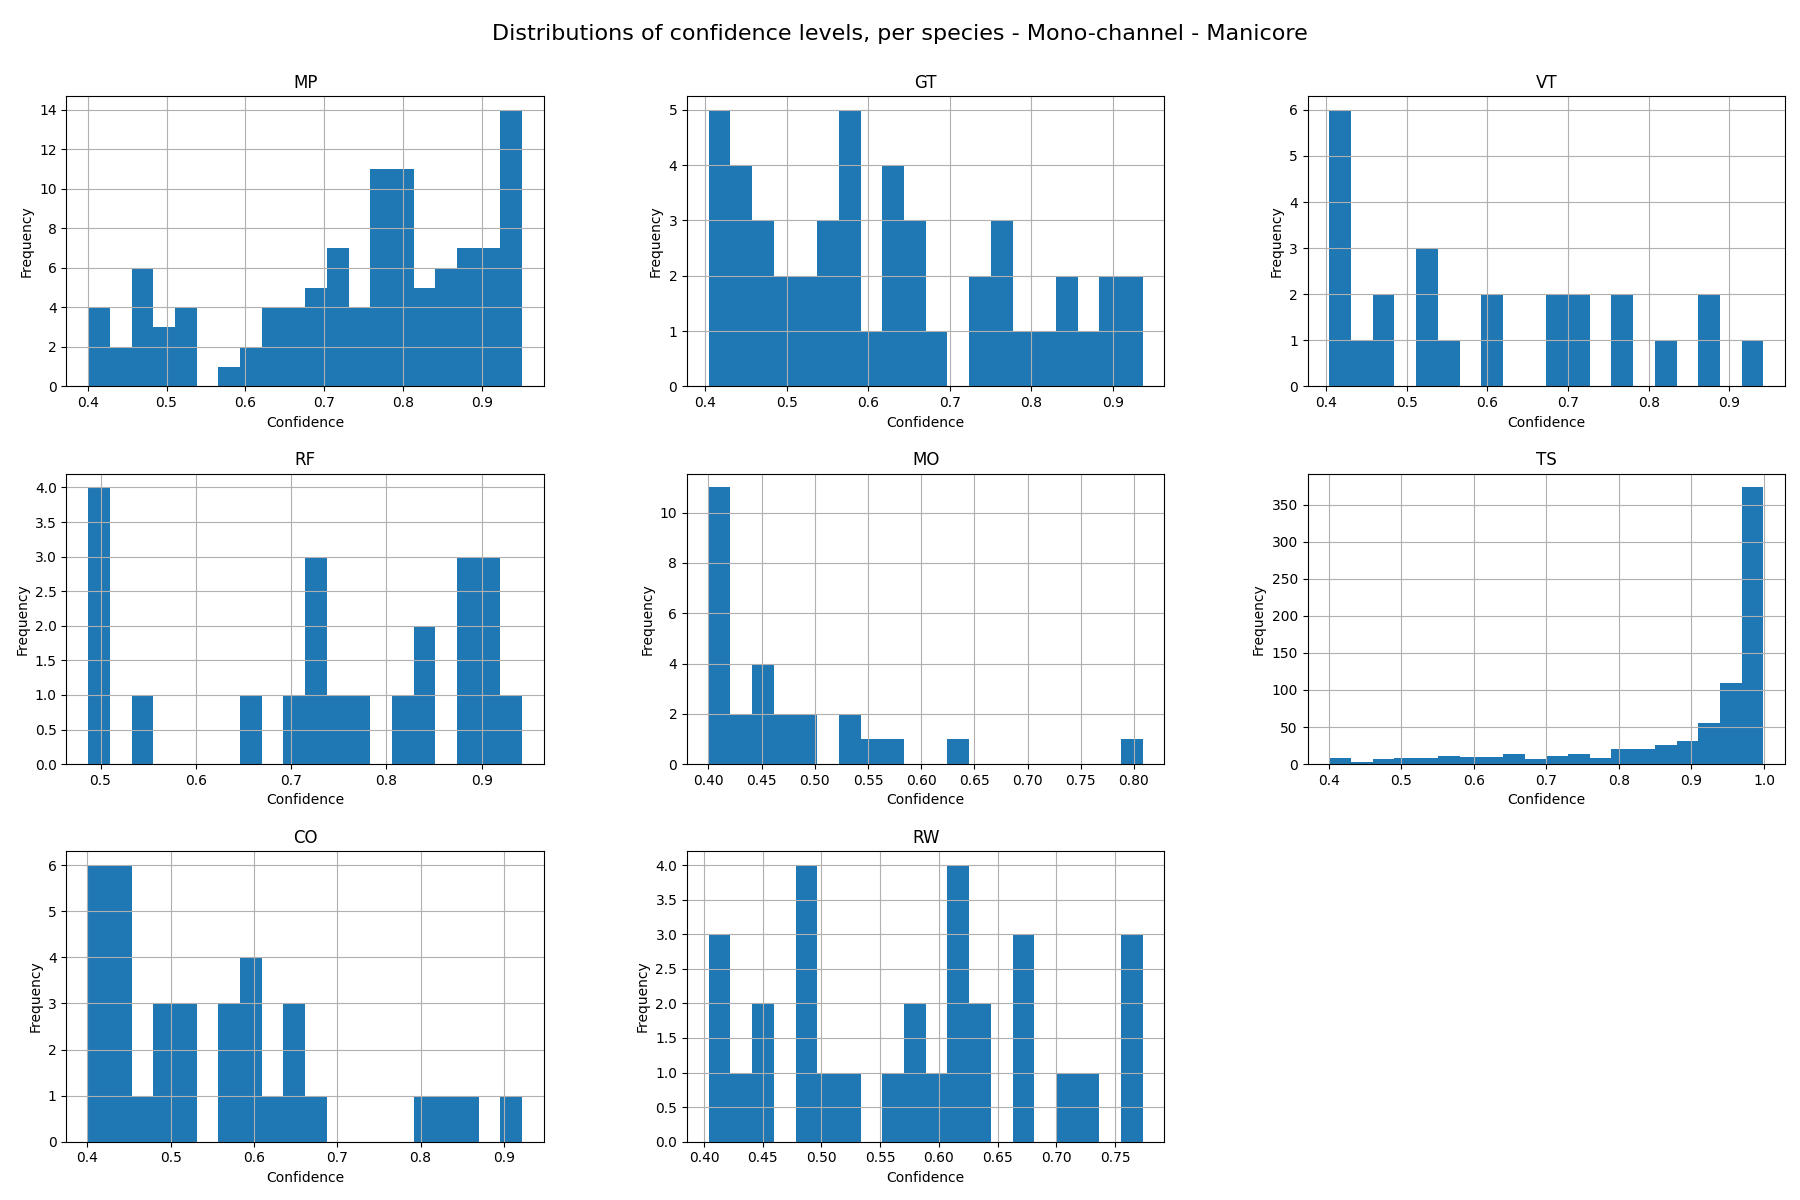

In [21]:
%matplotlib inline
from IPython.display import Image
Image('data/processed/manicore/mono_hists.png')
# Image('data/processed/silwood/A1/mono_hists.png')

We need to conduct statistical power analysis - to determine our minimum sample size required. For the Wilcoxon signed rank test, we must run a simulation-based power analysis. This requires an underlying model of our distribution...

Let's try find the best model for the TS distribution...

--> This should hopefully represent birdNET detections well as a whole (as we have almost 800 detections)
    --> If we calculate a min sample size for this (to give a good statistical power), we can then re-run our statistical inference tesMP over all species above the min sample size (above the threshold number of detections)

I've followed this article for fitting - https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

In [2]:
import json
from pprint import pprint

In [64]:
def read_results_from_file(file_path):
    """Read the BirdNET detections from a file"""

    with open(file_path, 'r') as file:
        results_dict = json.load(file)

    return results_dict

def setup_new_plot(xlabel, ylabel, title):
    """Initialises a new matplotlib plot, with desired parameters"""
    plt.figure(figsize=(18, 12))
    plt.xlabel(xlabel, fontsize=20, labelpad=20)
    plt.ylabel(ylabel, fontsize=20, labelpad=20)
    plt.tick_params(axis="both", labelsize=16)
    # plt.title(title)
    plt.grid(True)

# New colours
mono_col = '#18D12B'
bf_col = '#008CFF'

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions


mono_dict = read_results_from_file("data/processed/manicore/processed.json")["mono_channel"]

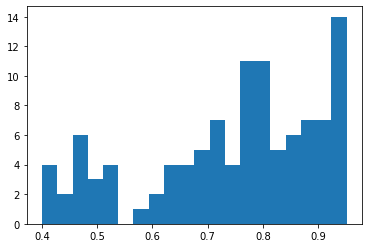

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,275.217323,-76.919009,119.777662,inf,0.095281,2.683454e-01
lognorm,355.415484,-59.349122,142.467562,inf,0.117767,9.473071e-02
gamma,361.863957,-60.685295,144.391513,inf,0.128164,5.429191e-02
rayleigh,397.591874,-74.871730,149.793558,inf,0.177201,2.072125e-03
expon,493.789571,-49.409296,172.978684,inf,0.283077,4.438658e-08


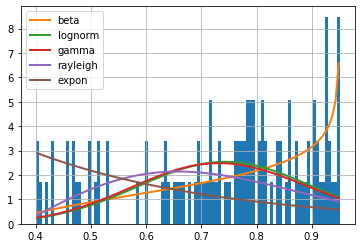

In [102]:
# Same, but for the Mealy Parrot...

MP_conf = mono_dict["Mealy Parrot"]["conf_list"]

plt.hist(MP_conf, bins=20)
plt.show()

f2 = Fitter(MP_conf,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "expon",
                          "rayleigh"])

# Alternatively, try all types of distribution (will take much longer to run)
# f = Fitter(TS_conf)

f2.fit()
f2.summary()

# pprint(f2.get_best(method="sumsquare_error"))


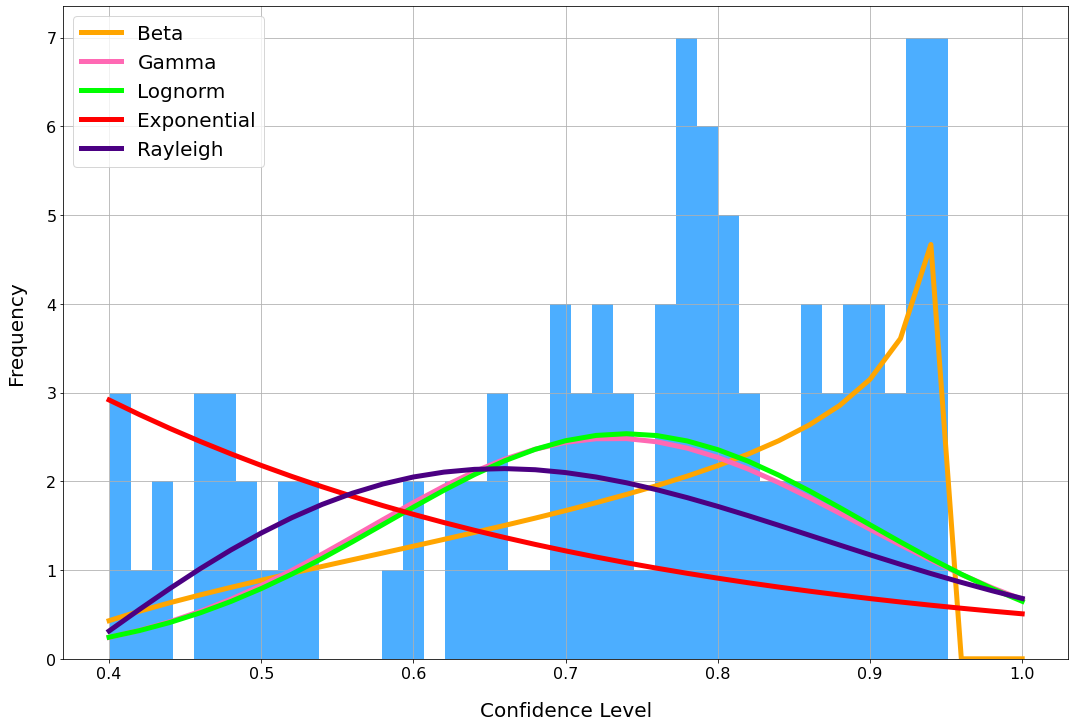

In [131]:
# Plot the different models...
from scipy.stats import beta, gamma, lognorm, expon, rayleigh

# Plot distribution
setup_new_plot("Confidence Level", "Frequency", "")
plt.hist(MP_conf, bins=40, color=bf_col, alpha=0.7)

x = np.arange(0.4, 1.02, 0.02)

# Plot beta fit
beta_pdf = beta.pdf(x, 1.5718, 0.7655, loc=0.3558, scale=0.5956)
plt.plot(x, beta_pdf, label='Beta', color='#FFA500', linewidth=5)

# Gamma
gamma_pdf = gamma.pdf(x, 248.54, loc=-1.794, scale=0.0102)
plt.plot(x, gamma_pdf, label='Gamma', color='#FF69B4', linewidth=5)

# Lognorm
lognorm_pdf = lognorm.pdf(x, loc=-57.95, s=0.00268, scale=58.69)
plt.plot(x, lognorm_pdf, label='Lognorm', color='#00FF00', linewidth=5)

# Expon
expon_pdf = expon.pdf(x, loc=0.4, scale=0.3429)
plt.plot(x, expon_pdf, label='Exponential', color='#FF0000', linewidth=5)

# Rayleigh
rayleigh_pdf = rayleigh.pdf(x, loc=0.3748, scale=0.283)
plt.plot(x, rayleigh_pdf, label='Rayleigh', color='#4B0082', linewidth=5)

plt.legend(fontsize=20)

plt.show()


In [34]:
pprint(f2.get_best(method="sumsquare_error"))

{'beta': {'a': 1.5718154845395125,
          'b': 0.7655057781029281,
          'loc': 0.3557972880305498,
          'scale': 0.5955634144840988}}


It seems like the best-fit model is the Beta distribution. 

See this page for info on the beta distribution (mean, stdev, alpha, beta) - https://www.wolframalpha.com/input?i=beta+distribution

See this thread for calculating alpha and beta, from mean and stdev - https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance

Let's use this to conduct our simulated statistical power analysis...

In [ ]:
# Playing around with the beta dist...

import scipy.stats as stats

# Assuming you have a dataset stored in the variable 'data'
data = mono_dict["Mealy Parrot"]["conf_list"]

# Fit the Beta distribution to the data
alpha_hat, beta_hat, loc_hat, scale_hat = stats.beta.fit(data)

# Print the estimated shape parameters
print("Estimated alpha:", alpha_hat)
print("Estimated beta:", beta_hat)
print("Estimated loc:", loc_hat)
print("Estimated scale:", scale_hat)


mean = alpha_hat/(alpha_hat + beta_hat)
est_mean = scale_hat*(alpha_hat/(alpha_hat + beta_hat))+loc_hat
print(est_mean)

variance = (alpha_hat*beta_hat)/(((alpha_hat+beta_hat)**2)*(alpha_hat+beta_hat+1))
print(variance)

effect_size = 0.1

new_mean = est_mean + effect_size

new_mean_inv = (new_mean-loc_hat)/scale_hat


alpha = ((1 - mean) / variance - 1 / mean) * mean**2
beta = alpha * (1 / mean - 1)

print("Alpha:", alpha)
print("Beta:", beta)


new_alpha = ((1 - new_mean_inv) / variance - 1 / new_mean_inv) * new_mean_inv**2
new_beta = new_alpha * (1 / new_mean_inv - 1)

print("New Alpha:", new_alpha)
print("New Beta:", new_beta)

In [121]:
from scipy.stats import wilcoxon, beta

# Set the parameters for the power analysis
effect_size = 0.1
alpha = 0.05

# Define the function to calculate power
def calculate_power(n, a, b, loc, scale):
    num_simulations = 1000  # Number of simulations
    rejected = 0  # Counter for rejected null hypotheses

    for i in range(num_simulations):
        # Generate synthetic data with the desired effect size
        sample1 = beta.rvs(a=a, b=b, loc=loc, scale=scale, size=n)

        mean = a/(a + b)
        actual_mean = scale*(mean)+loc

        variance = (a*b)/(((a+b)**2)*(a+b+1))

        new_mean = actual_mean + effect_size

        new_mean_inv = (new_mean-loc)/scale

        new_a = ((1 - new_mean_inv) / variance - 1 / new_mean_inv) * new_mean_inv**2
        new_b = new_a * (1 / new_mean_inv - 1)

        sample2 = beta.rvs(a=new_a, b=new_b, loc=loc, scale=scale, size=n)

        # Perform the Wilcoxon signed-rank test
        i, p_value = wilcoxon(sample1, sample2, alternative='two-sided')

        # Check if the null hypothesis is rejected
        if p_value < alpha:
            rejected += 1

    # Calculate the power
    power_estimate = rejected / num_simulations
    return power_estimate

In [123]:
# For the Mealy Parrot--------------------------------------

# Extract the parameters from our distributions (fitted previously)
fit_params_MP = f2.get_best(method="sumsquare_error")
a_MP = fit_params_MP["beta"]["a"]
b_MP = fit_params_MP["beta"]["b"]
loc_MP = fit_params_MP["beta"]["loc"]
scale_MP = fit_params_MP["beta"]["scale"]
print(f"{a_MP}, {b_MP}, {loc_MP}, {scale_MP}")

# Perform the power analysis for different sample sizes
sample_sizes = [10, 20, 30, 40, 50]
for n in sample_sizes:
    power_estimate = calculate_power(n, a_MP, b_MP, loc_MP, scale_MP)
    print(f"Sample Size: {n}, Power: {power_estimate}")

1.5718154845395125, 0.7655057781029281, 0.3557972880305498, 0.5955634144840988
Sample Size: 10, Power: 0.322
Sample Size: 20, Power: 0.562
Sample Size: 30, Power: 0.776
Sample Size: 40, Power: 0.876
Sample Size: 50, Power: 0.944


So, it seems that a sample size > 30 will be good for our tests!

Let's run the Wilcoxon tests!

In [124]:
def get_species_mean_med_dev(file_path, species_name):
    """Returns the means, medians and standard deviations of a species,
    rounded to 2 d.p, for both beamformed [0] and mono [1] channels"""

    bf_dict = read_results_from_file(file_path)["beamformed"]
    mono_dict = read_results_from_file(file_path)["mono_channel"]

    means = [round(bf_dict[species_name]["conf_avg"], 2), round(mono_dict[species_name]["conf_avg"], 2)]
    medians = [round(bf_dict[species_name]["conf_median"], 2), round(mono_dict[species_name]["conf_median"], 2)]
    devs = [round(bf_dict[species_name]["conf_stdev"], 2), round(mono_dict[species_name]["conf_stdev"], 2)]

    return means, medians, devs

In [6]:
from pprint import pprint

# signifance_level = 0.05

signifance_level = 0.05/24      # Using the Bonferroni

def report_outcome(means, medians, devs, w_val, p_val, z_val):
    if p_val < 0.05:
        p_val = round(p_val, 3)

        if p_val < 0.001:
            p_str = "p<0.001"
        else:
            p_str = "p=" + str(p_val)

        print(f"The data is not normally distributed, and descriptive analysis shows \nthat"
            + f" the mean confidence level using beamforming ({str(means[0])}, StDev={str(devs[0])})"
            + f" is higher\nthan the mean confidence level using the mono-channel benchmark"
            + f" recordings \n({str(means[1])}, StDev={str(devs[1])}). It is also noted that the median"
            + f" for beamforming ({str(medians[0])})\nis higher than the median for the mono-channel"
            + f" recordings ({str(medians[1])}).\n\n"
            + f"Non parametric statistics has been used. Wilcoxon signed rank test analysis shows\n"
            + f"that this difference is significant (W={str(w_val)}, Z={str(z_val)}, {p_str}).")
    else:
        print("Not significant!")

In [82]:
# Tawny-bellied Screech-Owl, from Manicore data...

manicore_file_path = "data/processed/manicore/processed.json"
species = "Tawny-bellied Screech-Owl"

mono_dict = read_results_from_file(manicore_file_path)["mono_channel"]
bf_dict = read_results_from_file(manicore_file_path)["beamformed"]

means, medians, devs = get_species_mean_med_dev(manicore_file_path, species)

TS_conf_mono = mono_dict[species]["conf_list"]
TS_conf_bf = bf_dict[species]["conf_list"]

# Note - put beamformed first (as the "x" values), as it will calculate x-y for the differences
statistic, p_value = wilcoxon(TS_conf_bf, TS_conf_mono, alternative="two-sided")

# Print the test statistic and p-value
print("Two-sided test (is there a signifcant difference)---------------------------")
print("Test Statistic:", statistic)
print("P-value:", p_value)

# Now, repeat with one-sided (to prove conf levels are better after beamforming)
statistic, p_value = wilcoxon(TS_conf_bf, TS_conf_mono, alternative="greater")

# Print the test statistic and p-value
print("Greater test (is the beamformed confidence data signifcantly higher)--------")
print("Test Statistic:", statistic)
print("P-value:", p_value)

report_outcome(means, medians, devs, statistic, p_value)


Two-sided test (is there a signifcant difference)---------------------------
Test Statistic: 42382.0
P-value: 3.3319992088054373e-62
Greater test (is the beamformed confidence data signifcantly higher)--------
Test Statistic: 240746.0
P-value: 1.6659996044027186e-62


The data is not normally distributed, and descriptive analysis shows 
that the mean confidence level using beamforming (0.96, StDev=0.074) is higher
than the mean confidence level using the mono-channel benchmark recordings 
(0.905, StDev=0.139). It is also noted that the median for beamforming (0.986)
is higher than the median for the mono-channel recordings (0.969).

Non parametric statistics has been used. Wilcoxon signed rank test analysis shows
that this difference is significant (Z=240746.0, p<0.001).


Let's do some sanity checks...

i.e., for some species that appeared much closer (in confidence levels)...

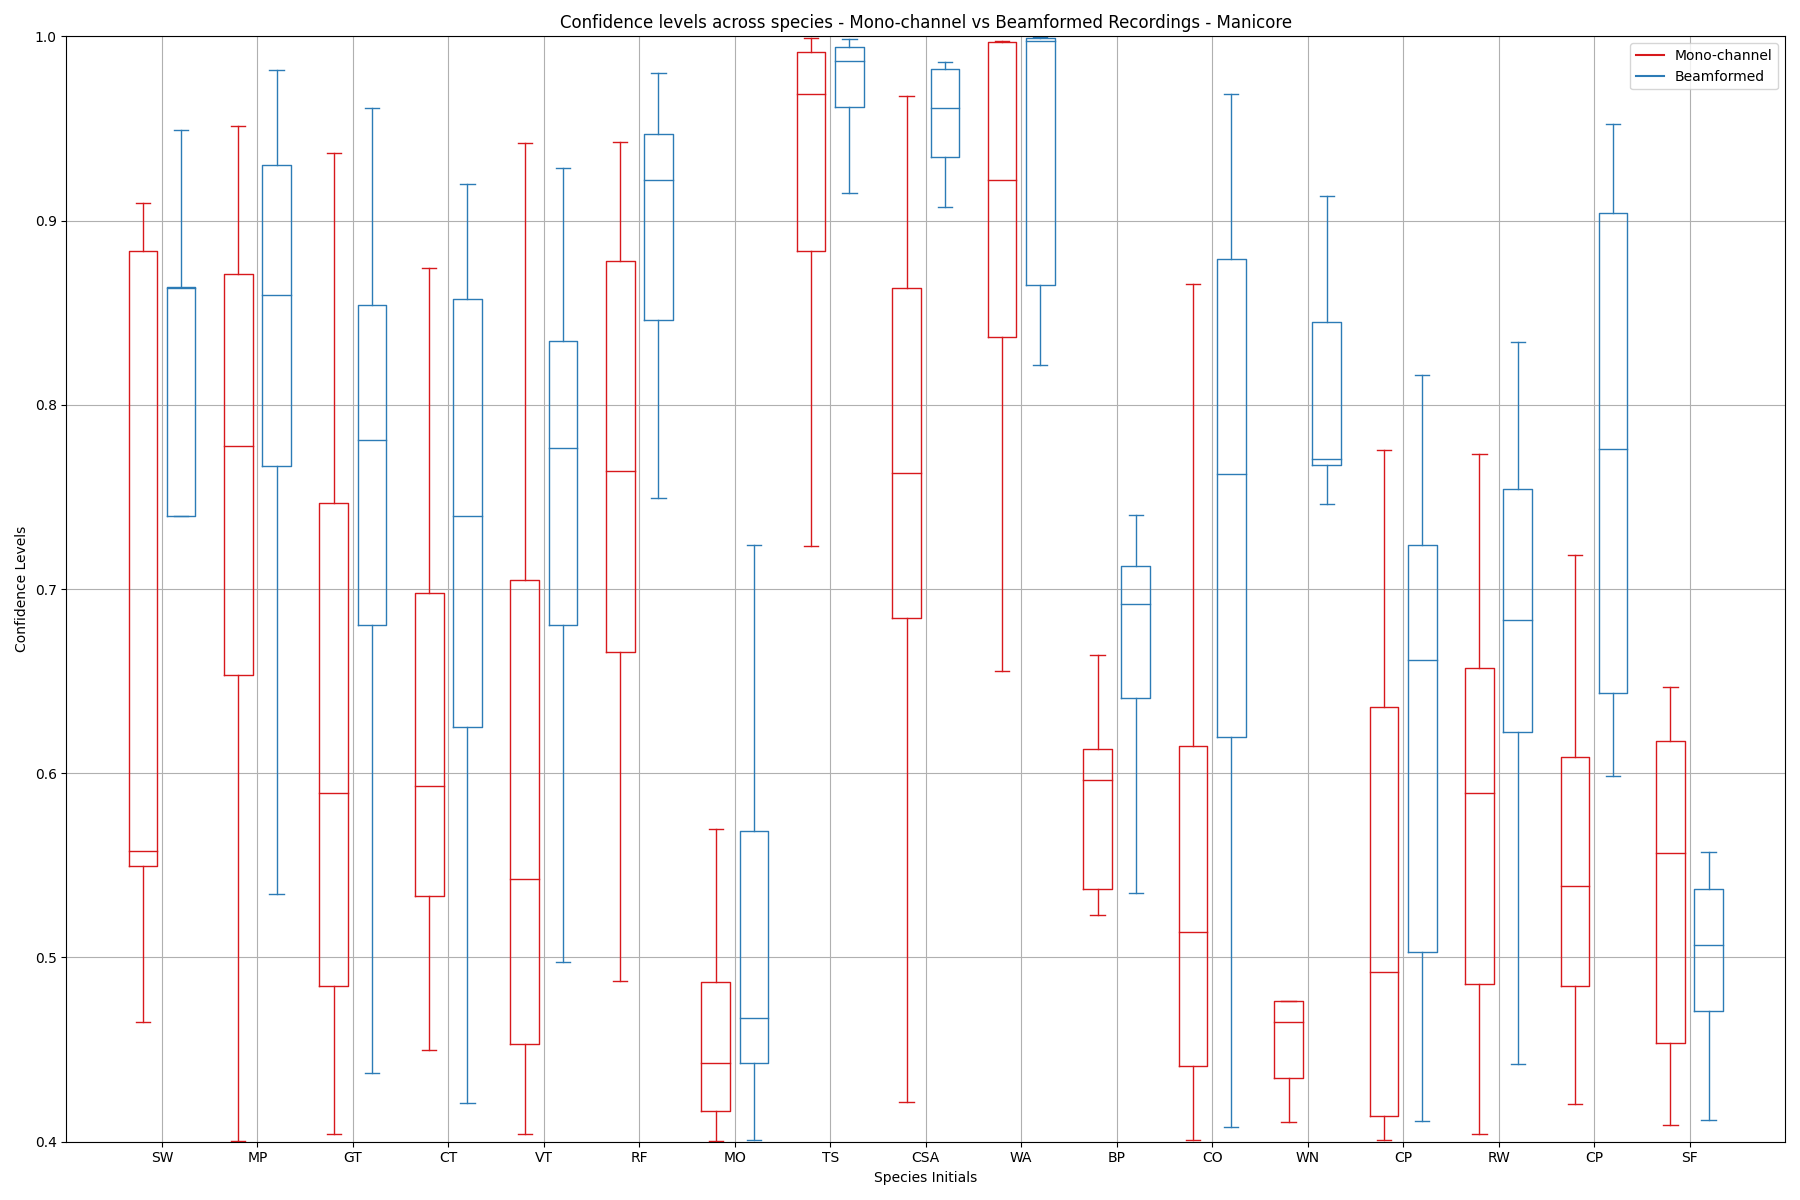

In [66]:
Image('data/processed/manicore/boxcompare.png')

In [65]:
# Slaty-backed Forest-Falcon - see boxplots (above) - beamformed is actually worse

SF_conf_mono = mono_dict["Slaty-backed Forest-Falcon"]["conf_list"]
SF_conf_bf = bf_dict["Slaty-backed Forest-Falcon"]["conf_list"]

statistic, p_value = wilcoxon(SF_conf_mono, SF_conf_bf, alternative="two-sided")

# Print the test statistic and p-value
print("Test Statistic:", statistic)
print("P-value:", p_value)

Test Statistic: 11.0
P-value: 0.3828125


In [90]:
# Mottled Owl - bf median falls within the mono's IQ range

manicore_file_path = "data/processed/manicore/processed.json"
species = "Mottled Owl"

MO_conf_mono = mono_dict[species]["conf_list"]
MO_conf_bf = bf_dict[species]["conf_list"]

statistic, p_value = wilcoxon(MO_conf_mono, MO_conf_bf, alternative="two-sided")

means, medians, devs = get_species_mean_med_dev(manicore_file_path, species)

# Print the test statistic and p-value
print("Two-sided test (is there a signifcant difference)---------------------------")
print("Test Statistic:", statistic)
print("P-value:", p_value)

# Now, repeat with one-sided (to prove conf levels are better after beamforming)
statistic, p_value = wilcoxon(MO_conf_bf, MO_conf_mono, alternative="greater")

# Print the test statistic and p-value
print("Greater test (is the beamformed confidence data signifcantly higher)--------")
print("Test Statistic:", statistic)
print("P-value:", p_value)
print()

report_outcome(means, medians, devs, statistic, p_value)

Two-sided test (is there a signifcant difference)---------------------------
Test Statistic: 116.0
P-value: 0.08148856461048126
Greater test (is the beamformed confidence data signifcantly higher)--------
Test Statistic: 262.0
P-value: 0.04074428230524063

The data is not normally distributed, and descriptive analysis shows 
that the mean confidence level using beamforming (0.51, StDev=0.1) is higher
than the mean confidence level using the mono-channel benchmark recordings 
(0.47, StDev=0.09). It is also noted that the median for beamforming (0.47)
is higher than the median for the mono-channel recordings (0.44).

Non parametric statistics has been used. Wilcoxon signed rank test analysis shows
that this difference is significant (Z=262.0, p=0.041).


Now, let's do it for all species in a processed file...

In [125]:
import math
from scipy.stats import norm

def wilcoxon_each_species(file_path):
    """Takes a processed.json file/dictionary
    --> For all species, runs a Wilcoxon Signed Rank Test
    --> Reports the number of significant/not-significant tests (and which species)"""
    
    mono_dict = read_results_from_file(file_path)["mono_channel"]
    bf_dict = read_results_from_file(file_path)["beamformed"]

    alternate_count = 0
    total_count = 0
    # signifance_level = 0.05
    signifance_level = 0.05/13      # Bonferroni Correction - 13 species, thus, 13 tests

    significant_species = []
    null_species = []

    summary_table = {}

    sample_threshold = 30           # Minimum num of samples required, for power high enough to show signifance
    # (lower threshold = more tests are not significant)

    # Iterate through all species
    for species in mono_dict.keys():
        if bf_dict[species]["count"] > sample_threshold:
            total_count += 1

            # Extract confidence lists
            conf_bf = bf_dict[species]["conf_list"]
            conf_mono = mono_dict[species]["conf_list"]

            sample_size = len(conf_bf)
            
            # Conduct Wilcoxon signed rank test (one-tail - greater than)
            statistic, p_value = wilcoxon(conf_bf, conf_mono, alternative="greater")

            z_stat = round(norm.ppf(p_value), 2)*-1         # Reverse engineering the z-val, from the p-val (based on normal approximation)

            # n = sample_size
            # W = statistic           # Note, Wicoxon test statistic (W) is sometimes also denoted as T 
            # z_stat_alt = round((W - ((n*(n+1))/4))/math.sqrt((n*(n+1)*(2*n+1))/24), 2)

            summary_table[species] = [statistic, z_stat, p_value, sample_size]       # Record the results

            if p_value < signifance_level:
                alternate_count += 1            # Reject null hypothesis
                significant_species.append(species)
            else:                               # Accept null hypothesis
                null_species.append(species)

    print(f"{str(alternate_count)}/{str(total_count)} tests showed that beamforming led to significantly higher confidence levels.\n"
        +f"Species whose tests showed significance: {significant_species}\n"
        +f"Species whose tests showed no signficance: {null_species}")
    
    print("[w_stat, z_stat, p_value, sample_size]")

    pprint(summary_table)

In [126]:
manicore_file_path = "data/processed/manicore/processed.json"
silwood_file_path = "data/processed/silwood/A1/processed.json"
lab_file_path = "data/processed/speaker_sphere_lab_tests/processed.json"

print("Manicore - Amazonas, Brazil: ")
wilcoxon_each_species(manicore_file_path)
print()

print("Silwood Park - Reading, UK")
wilcoxon_each_species(silwood_file_path)
print()

# print("Lab Tests - Speaker Sphere")
# wilcoxon_each_species(lab_file_path)
# print()

Manicore - Amazonas, Brazil: 
4/4 tests showed that beamforming led to significantly higher confidence levels.
Species whose tests showed significance: ['Mealy Parrot', 'Green-backed Trogon', 'Tawny-bellied Screech-Owl', 'Crested Owl']
Species whose tests showed no signficance: []
[w_stat, z_stat, p_value, sample_size]
{'Crested Owl': [603.0, 5.38, 3.66999302059412e-08, 35],
 'Green-backed Trogon': [1092.0, 6.52, 3.537081738613779e-11, 47],
 'Mealy Parrot': [5020.0, 6.62, 1.7578503012167485e-11, 107],
 'Tawny-bellied Screech-Owl': [240746.0, 16.64, 1.6659996044027186e-62, 752]}

Silwood Park - Reading, UK
9/9 tests showed that beamforming led to significantly higher confidence levels.
Species whose tests showed significance: ['Eurasian Jackdaw', 'Carrion Crow', 'Eurasian Nuthatch', 'Eurasian Green Woodpecker', 'Eurasian Blue Tit', 'Great Spotted Woodpecker', 'Great Tit', 'Stock Dove', 'Coal Tit']
Species whose tests showed no signficance: []
[w_stat, z_stat, p_value, sample_size]
{'Car

Grace & Lorenzo suggested just running one single Wilcoxon test - combining the confidence readings for all species

Let's do this (for Amazon & Silwood data)...

In [60]:
import matplotlib.pyplot as plt

def set_box_color(bp, color):
    """Sets the colours of a single box, from a matplotlib boxplot"""
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


def get_initials(species_name):
    """Extract the intials from a species' full name"""
    # Split the name into individual words
    words = species_name.split()

    # Extract the first character of each word
    initials = [word[0].upper() for word in words]

    # Return the initials as a string
    return ''.join(initials)

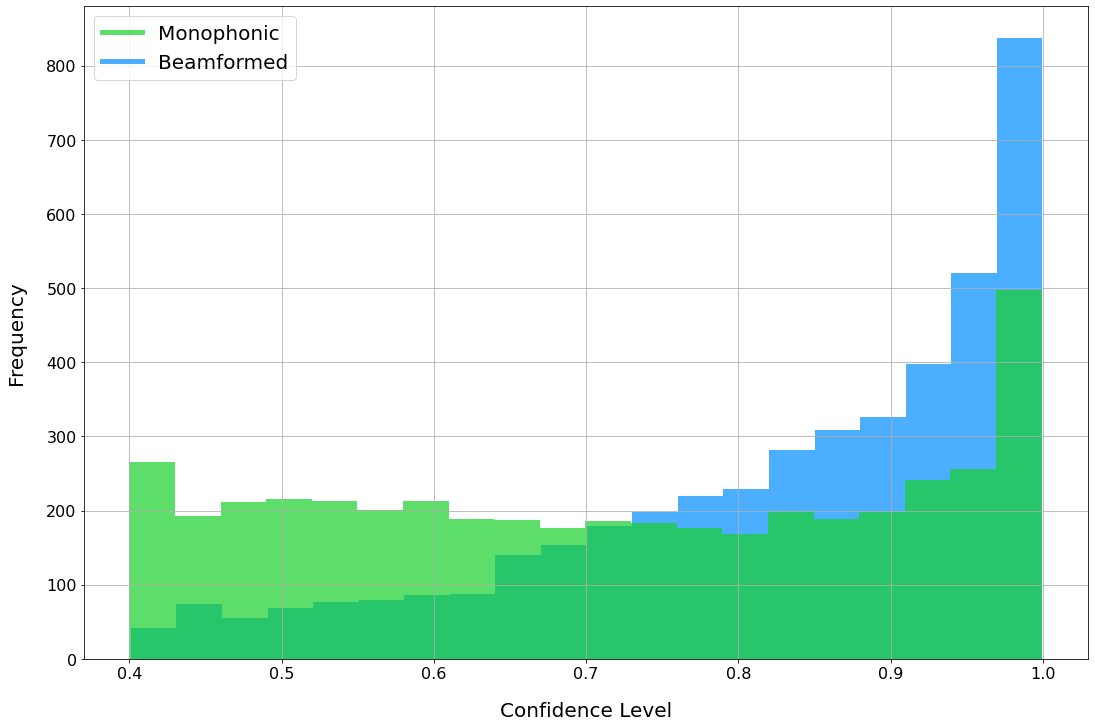

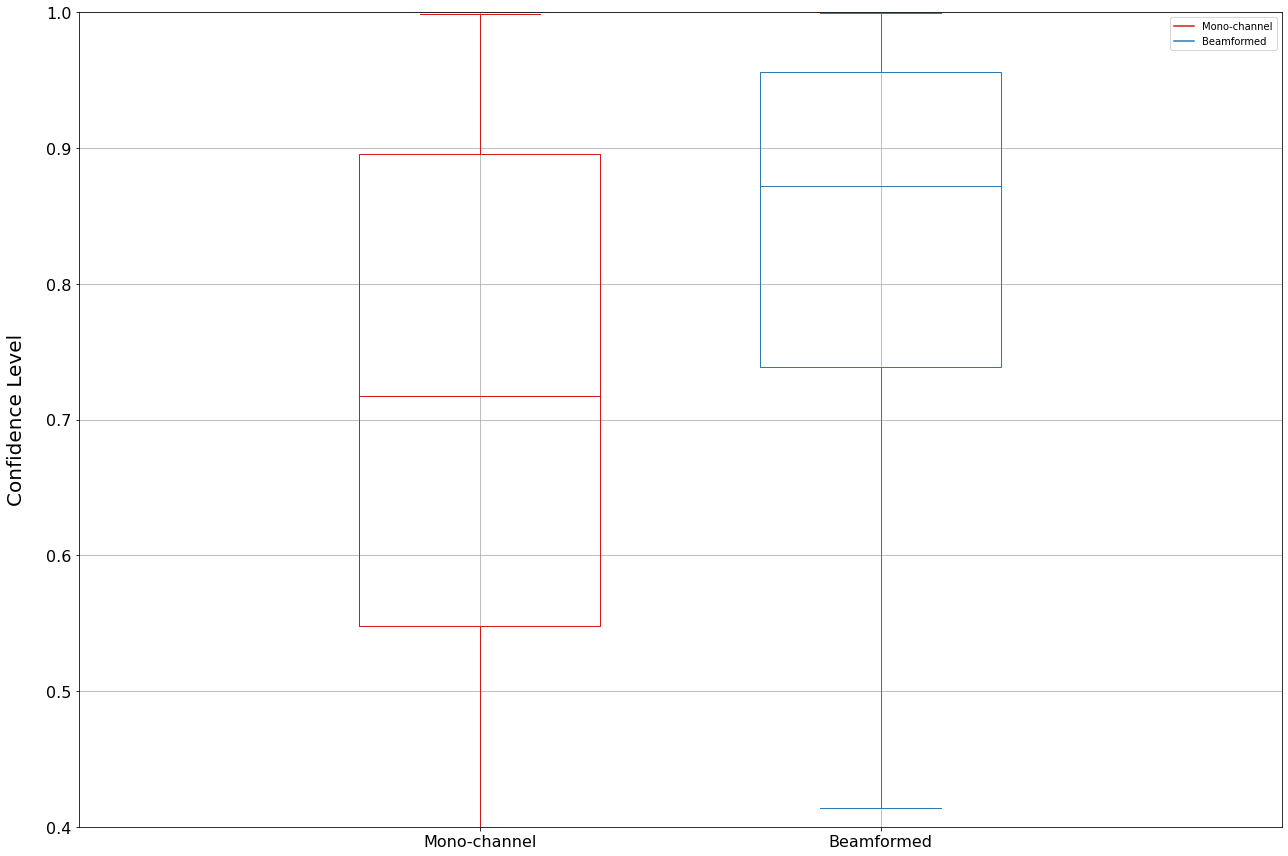

Sample Size: 4358

zval = 44.64
0.0

The data is not normally distributed, and descriptive analysis shows 
that the mean confidence level using beamforming (0.83, StDev=0.151) is higher
than the mean confidence level using the mono-channel benchmark recordings 
(0.717, StDev=0.189). It is also noted that the median for beamforming (0.872)
is higher than the median for the mono-channel recordings (0.718).

Non parametric statistics has been used. Wilcoxon signed rank test analysis shows
that this difference is significant (W=8457060.0, Z=44.64, p<0.001).


In [130]:
import numpy as np
from scipy.stats import norm
import math

# # Old colours
# mono_col = '#D7191C'
# bf_col = '#2C7BB6'

# New colours
mono_col = '#18D12B'
bf_col = '#008CFF'

# List for every single detection
conf_bf = []
conf_mono = []

# Add all detections from Manicore-------------------------------------------
manicore_file_path = "data/processed/manicore/processed.json"

mono_dict = read_results_from_file(manicore_file_path)["mono_channel"]
bf_dict = read_results_from_file(manicore_file_path)["beamformed"]

# Iterate through all species
for species in mono_dict.keys():
    # Extract confidence lists
    conf_bf.extend(bf_dict[species]["conf_list"])
    conf_mono.extend(mono_dict[species]["conf_list"])

# Add all detections from Silwood-------------------------------------------
silwood_file_path = "data/processed/silwood/A1/processed.json"

mono_dict = read_results_from_file(silwood_file_path)["mono_channel"]
bf_dict = read_results_from_file(silwood_file_path)["beamformed"]

# Iterate through all species
for species in mono_dict.keys():
    # Extract confidence lists
    conf_bf.extend(bf_dict[species]["conf_list"])
    conf_mono.extend(mono_dict[species]["conf_list"])


# Plot the data (histograms & boxplots)-------------------------------------
# Histograms---
# setup_new_plot("Confidence Level", "Frequency", "Confidence Level Historgrams - Mono-channel - All Species Combined")

# plt.hist(conf_mono, bins=20, color='#D7191C')
# plt.show()

# setup_new_plot("Confidence Level", "Frequency", "Confidence Level Historgrams - Beamformed - All Species Combined")

# plt.hist(conf_bf, bins=20)
# plt.show()

# Overlay the histograms...
setup_new_plot("Confidence Level", "Frequency", "")

overlay_alpha = 0.7

plt.hist(conf_bf, bins=20, color=bf_col, alpha=overlay_alpha)
plt.hist(conf_mono, bins=20, color=mono_col, alpha=overlay_alpha)

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c=mono_col, label='Monophonic', alpha=overlay_alpha)
plt.plot([], c=bf_col, label='Beamformed', alpha=overlay_alpha)
leg = plt.legend(fontsize=20)

leg.get_lines()[0].set_linewidth(5)
leg.get_lines()[1].set_linewidth(5)

plt.show()

# Boxplots---
setup_new_plot("", "Confidence Level", "Confidence Levels - All Species Combined")

bpl = plt.boxplot(conf_mono, positions=[-1], sym='', widths=0.6)
bpr = plt.boxplot(conf_bf, positions=[0], sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Mono-channel')
plt.plot([], c='#2C7BB6', label='Beamformed')
plt.legend()

boxplot_labels = ["Mono-channel", "Beamformed"]
plt.xticks([-1, 0], boxplot_labels)
plt.xlim(-2, 1)
plt.ylim(0.4, 1)
plt.tight_layout()

plt.show()

# Calculate important metrics-----------------------------------------------
means = [round(np.mean(conf_bf), 3), round(np.mean(conf_mono), 3)]
medians = [round(np.median(conf_bf), 3), round(np.median(conf_mono), 3)]
devs = [round(np.std(conf_bf), 3), round(np.std(conf_mono), 3)]

sample_size = len(conf_bf)
print("Sample Size: " + str(sample_size))
print()

# Conduct the Significance Test---------------------------------------------
statistic, p_value = wilcoxon(conf_bf, conf_mono, method="approx", alternative="greater")

# print(p_value)
# z_statistic = norm.ppf(p_value)         # Reverse engineering the z-val, from the p-val (based on normal approximation)
# print(f"zval = {z_statistic}")          # Unfortunately p_value = 0.0 (i.e., not 0.00000..1 - likely because it's smaller than the amount of bits we can store)
#                                                 # Thus, this method gives z_statistic = inf

# Alternate method for z-val, based on this article http://www.statisticslectures.com/topics/wilcoxonsignedranks/ 
# (Matlab also uses the same method - https://uk.mathworks.com/help/stats/signrank.html - see 'More About -> z-Statistic)
n = sample_size
W = statistic           # Note, Wicoxon test statistic (W) is sometimes also denoted as T 
z_statistic = round((W - ((n*(n+1))/4))/math.sqrt((n*(n+1)*(2*n+1))/24), 2)
print(f"zval = {z_statistic}")

print(norm.cdf(-z_statistic))        # We can then calculate p-val, based on the z-val (from the normal dist) -> Again, = 0.0 (too small for num of bits)
print()

report_outcome(means, medians, devs, statistic, p_value, z_statistic)

Grace also recommended doing a 'Shapiro Test for Normality' (to prove that the data is non-normal)

1. Michel's lecture notes suggest this is not necessary (unless it's a bit difficult to tell - usually, eyeballing is fine)
2. This paper: "Descriptive Statistics and Normality Tests for Statistical Data"
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/#:~:text=The%20Shapiro–Wilk%20test%20is,taken%20from%20normal%20distributed%20population.
    ...states that "The Shapiro–Wilk test is more appropriate method for small sample sizes (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥50. For both of the above tests, null hypothesis states that data are taken from normal distributed population."
    -> We have so many samples (>4000), thus, we should use the KS test instead

In [37]:
from scipy.stats import kstest
import numpy as np


# For Mono-Channel-------------------------------------------
# Perform Kolmogorov-Smirnov test
statistic, p_value = kstest(conf_mono, 'norm')

# Print the test statistic and p-value
print(f"Kolmogorov-Smirnov test statistic: {statistic}")
print(f"P-value: {p_value}")
print()

# For Beamformed---------------------------------------------
# Perform Kolmogorov-Smirnov test
statistic, p_value = kstest(conf_bf, 'norm')

# Print the test statistic and p-value
print(f"Kolmogorov-Smirnov test statistic: {statistic}")
print(f"P-value: {p_value}")
print()

Kolmogorov-Smirnov test statistic: 0.6554294703879789
P-value: 0.0

Kolmogorov-Smirnov test statistic: 0.6573469057683892
P-value: 0.0

